In [40]:
import gensim
import gensim.models as g
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import tensorflow.keras.layers as layers
import word2vec
from gensim.models import Word2Vec
from gensim.utils import tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import re
import string
import tqdm
import io
from sklearn.decomposition import PCA

Imports the data and turns it into a list of individual messages

In [32]:
data = (
    pd.read_csv("../data/daniel.csv")
    .loc[:, "Contents"]
    .dropna(how="any")
    .apply(lambda x: x.lower())
    .apply(tokenize)
    .apply(list)
    .tolist()
)
data[1:5]

[['a', 'gardener', 'nurturing', 'new', 'technologies'],
 ['more', 'or', 'less', 'that', 'yeah'],
 ['class', 'traitor', 'got', 'what', 'he', 'had', 'coming', 'smh'],
 ['now', 'i', 'get', 'chat', 'gtp', 'to', 'be', 'code', 'monke', 'for', 'me']]

Removes punctuation, makes sentences lowercase, and sets up list of vocabulary

In [33]:
model = Word2Vec(data, min_count = 5)

In [27]:
interesting_word_list = [
    'meme',
    'socialism',
    'communism',
    'magic',
    'pain',
    'systems',
    'rootwalla',
    'magic',
    'bread',
    'politics',
    'lizard',
    'nuclear',
    'politics',
    'psci',
    'political',
    'lizard',
    'wizard',
    'cookies'
]

In [28]:
def lemmatize(word,lemmatizer):
    return lemmatizer.lemmatize(word)

def tokenize_and_stem(article,lemmatizer,MAX_WORD_LENGTH=30):
    """
        Apply nltk sentence tokenization and word tokenization.
    """
    # Preparing the dataset
    all_sentences = nltk.sent_tokenize(article)
    
    all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
    #print("Number of Words {}".format([len(item) for item in all_words]))
    
    for i in range(len(all_words)):
        all_words[i] = [lemmatize(w,lemmatizer) for w in all_words[i] if w not in stopwords.words('english') and len(w)<=MAX_WORD_LENGTH]
    
    return all_words

def phrase2vec(model,lemmatizer,phrase):
    """
        @param model: word2vec model.
        @param lemmatizer: The lemmatizer to be used.
        @param phrase: The phrase to get the word embedding for.
    """
    lemmatized_phrase=[lemmatize(w,lemmatizer) for w in phrase if w not in stopwords.words('english')]
    #word2vec.
    lemmatized_phrase_vector = model.wv[lemmatized_phrase].mean(axis=0)
    return (phrase,lemmatized_phrase,lemmatized_phrase_vector)
        
def create_pca(model):
    words = list(model.wv.index_to_key)

    #Instantiate Lemmatizer
    lemmatizer = WordNetLemmatizer()

    #Create vectors for seed phrases.
    phrase_vectors = dict()
    ignored_phrases = list()
    for idx, phrase in enumerate(interesting_word_list):
        try:
            _, lemmatized_phrase, lemmatized_phrase_vector = phrase2vec(model,lemmatizer, 
                                                                        phrase.strip().split(" "))
            phrase_vectors[phrase] = (lemmatized_phrase, lemmatized_phrase_vector)
#             if idx < 10:
#                 print("Phrase = {}, Lemmatized Phrase = {}, Vector Shape = {}\n\n".format(phrase,
#                                                                                           lemmatized_phrase,
#                                                                                           lemmatized_phrase_vector.shape))
        except KeyError:
            ignored_phrases.append(phrase)
    pca = PCA(n_components = 2)
    phrase_keys = list(phrase_vectors.keys())
    phrase_vecs = list()
    for phr in phrase_keys:
        phrase_vecs.append(phrase_vectors[phr][1][None,:])

    phrase_vecs = np.concatenate(phrase_vecs)

    pca_phrase_vecs = pca.fit_transform(phrase_vecs)
    return pca_phrase_vecs, phrase_keys, pca.components_


In [44]:
pca_vecs, phrase_keys, comp = create_pca(model)

(-10.0, 10.0)

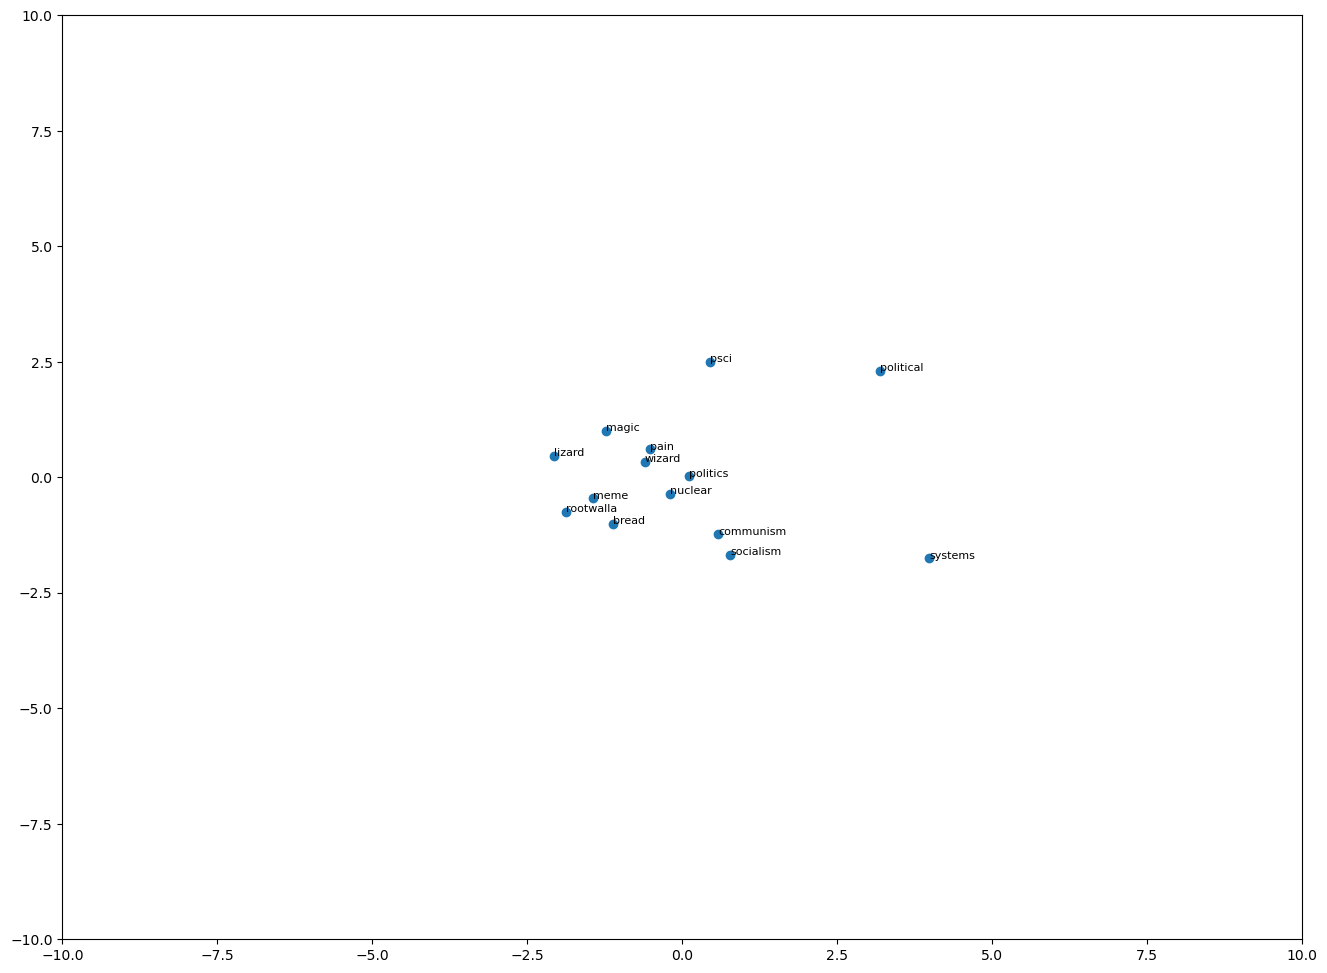

In [47]:
fig,ax = plt.subplots(1, 1, figsize = (16,12))
ax.scatter(pca_vecs[:,0],pca_vecs[:,1])

for i, txt in enumerate(phrase_keys):
    ax.annotate(txt, (pca_vecs[i,0], pca_vecs[i,1]),fontsize=8)
ax.set_ylim([-10, 10])
ax.set_xlim([-10, 10])
